### Data Handling & Importing Libraries ###

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re, string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer



In [2]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [5]:
!pip install symspellpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 9.2 MB/s eta 0:00:00


# STEP 1
### Text Preprocessing ###

### 1.1 lowercasing ###

In [6]:
df['review'] = df['review'].str.lower()

### 1.2 Removing HTML Tags ###


In [7]:
def remove_html(text):
    html = re.compile("<.*?>")
    return html.sub(r'', text)

df['review'] = df['review'].apply(remove_html)


### 1.3 Removing URLs ###


In [8]:
def remove_URL(text):
    URL = re.compile(r'https?://\S+|www\.\S+')
    return URL.sub(r'', text)

df['review'] = df['review'].apply(remove_URL)


### 1.4 Removing Punctuation ###

In [9]:
punct = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punct))

df['review'] = df['review'].apply(remove_punctuation)


### 1.5 Removing Emojis ###


In [10]:
def remove_emoji(text):
    emoji = re.compile(
        r"[" 
        u"\U0001F600-\U0001F64F"  u"\U0001F300-\U0001F5FF"  u"\U0001F680-\U0001F6FF"  u"\U0001F1E0-\U0001F1FF"  
        u"\U00002702-\U000027B0"  u"\U000024C2-\U0001F251"   u"\U0001D400-\U0001D7FF"  u"\U00020000-\U0002A6DF" 
        u"\U0001F000-\U0001F02F" 
        "]+", flags=re.UNICODE)
    return emoji.sub(r'', text)

df['review'] = df['review'].apply(remove_emoji)


### 1.6 Stopwords Removal ###

In [11]:
nlp = spacy.load('en_core_web_sm')

def remove_stopwords(text):
    stop = nlp(text)
    return ' '.join([token.text for token in stop if not token.is_stop])

df['review'] = df['review'].apply(remove_stopwords)


### 1.7 Lemmatization (using spaCy) ###

In [12]:
def lemmatize_review(review):
    doc = nlp(review)
    lemmatized_words = [token.lemma_ for token in doc]
    return " ".join(lemmatized_words)

df['review'] = df['review'].apply(lemmatize_review)


### 1.8 Slang & Abbreviations Correction ###

In [13]:

slang_dict = {"omg": "oh my god", "lol": "laugh out loud", "u": "you", "r": "are", "gr8": "great", "b4": "before", "asap": "as soon as possible", "btw": "", "fyi": "for your information", "idk": "i don't know", "imo": "in my opinion", "jk": "just kidding", "lmao": "laughing my ass off", "lmk": "let me know", "nvm": "nevermind", "np": "no problem", "rofl": "rolling on the floor laughing", "smh": "shaking my head", "tbh": "to be honest", "thx": "thanks", "ty": "thank you", "wth": "what the heck", "wtf": "what the f***", "yolo": "you only live once", "brb": "be right back", "gtg": "got to go", "btw": "by the way", "ttyl": "talk to you later", "ily": "I love you", "g2g": "got to go", "h8": "hate", "jk": "just kidding", "thx": "thanks", "ttyl": "talk to you later", "cya": "see you", "gg": "good game", "afk": "away from keyboard", "ez": "easy", "wb": "welcome back", "idc": "i don't care", "rn": "right now", "lmk": "let me know", "ikr": "i know right", "tmi": "too much information", "smh": "shaking my head", "w/e": "whatever", 
                 "bff": "best friends forever", "tfw": "that feeling when", "np": "no problem", "nvm": "nevermind", "fyi": "for your information", "cuz": "because", "gonna": "going to", "wanna": "want to", "gotta": "got to", "kinda": "kind of", "sorta": "sort of", "dunno": "don't know", "ain't": "is not", "gimme": "give me", "lemme": "let me", "im": "I'm", "hes": "he's", "shes": "she's", "theyre": "they're", "youre": "you're", "havent": "have not", "cant": "cannot",
                  "couldnt": "could not", "didnt": "did not", "doesnt": "does not", "dont": "do not", "isnt": "is not", "mightnt": "might not", "mustnt": "must not", "shouldnt": "should not", "wasnt": "was not", "werent": "were not", "wouldnt": "would not", "tho": "though", "thru": "through", "nite": "night", "neva": "never", "sum": "some", "dat": "that", "dis": "this", "dem": "them", "dey": "they", "em": "them", "whered": "where did", "whod": "who did", "whos": "who's", "yall": "you all", "dam": "damn", "hell": "hell", "pissed": "pissed", "fck": "fuck", "fuk": "fuck", "effing": "effing", "bs": "bullshit", "crap": "crap", "shitty": "shitty", "wtf": "what the fuck", "stfu": "shut the fuck up", "gtfo": "get the fuck out", "irl": "in real life", "roflmao": "rolling on the floor laughing my ass off", "smol": "small", "big oof": "huge mistake", "yeet": "throw something forcefully", "pog": "play of the game", "sus": "suspicious", "cap": "lie", "no cap": "no lie", "bet": "okay", "lit": "amazing", "fr": "for real", "bruh": "bro", "fam": "family",
                    "goat": "greatest of all time", "lowkey": "somewhat", "highkey": "very", "vibe": "mood", "drip": "fashionable", "slay": "do something well", "tea": "gossip", "sksksk": "excited reaction", "tf": "the fuck", "fomo": "fear of missing out", "tldr": "too long didn't read", "hmu": "hit me up", "wyd": "what you doing", "wym": "what you mean", "wdym": "what do you mean", "btw": "by the way", "imo": "in my opinion", "idc": "i don't care", 
                  "idgaf": "i don't give a f***", "frfr": "for real for real", "mf": "motherfucker", "rn": "right now", "lolz": "laughs", "hmu": "hit me up", "hbu": "how about you", "rn": "right now", "lmk": "let me know", "ikr": "i know right", "jk": "just kidding", "fr": "for real", "ffs": "for fuck's sake", "btw": "by the way", "nfs": "not for sale", "dm": "direct message", "af": "as fuck", "idk": "i don't know"}


def correct_slangs(text, slang_dict):
    for slang, replacement in slang_dict.items():
        text = re.sub(rf'\b{slang}\b', replacement, text)
    return text


df['review'] = df['review'].apply(lambda x: correct_slangs(x, slang_dict))

### 1.9  Spelling Correction ###

In [14]:
from symspellpy.symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

def spelling_correct(text):
    corrected = []
    for word in text.split():
        suggestion = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected.append(suggestion[0].term if suggestion else word)
    return " ".join(corrected)
txt = "awsome job now go on say sth new fck of, omg, whar a tyageedy"
spell_test = spelling_correct(txt)
spell_test
df['review'] = df['review'].apply(spelling_correct)

2025-03-02 11:45:24,835: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en_82_765.txt.


### 1.10 Sentiment Label Encoding ###

In [15]:
df['sentiment']= df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# STEP 2 
### Spliting the data into train validation and test ###

In [16]:
train, valid ,test = np.split(df.sample(frac=1), [int(0.7* len(df)), int(0.9* len(df))])

def split_data(dataframe):
    features = dataframe['review'].values
    labels = dataframe['sentiment'].values
    return features, labels

x_train, y_train = split_data(train)
x_valid, y_valid = split_data(valid)
x_test, y_test = split_data(test)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [17]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((35000,), (35000,), (10000,), (10000,), (5000,), (5000,))

# Step 3 - Step 4
### Feature Extraction & Representation and Model Training and Evaluation ###

# Binary Count Vectorizer (5,000 Features) 


### Models (SVM, Logistic Regression, KNN, Random Forests, XGBoost, Multinomial Naive Bayes, XGBoost)###
### Binary 50000 ###

In [18]:
v = CountVectorizer(binary=True, lowercase=False, stop_words=None, max_features=5000)
x_train_cvb5 = v.fit_transform(x_train)
x_valid_cvb5 = v.transform(x_valid)
x_test_cvb5 = v.transform(x_test)

In [19]:
# SVM
svcb5 = SVC()
svcb5.fit(x_train_cvb5, y_train)
svcb5_perd = svcb5.predict(x_test_cvb5)
print("SVM - Classification Report:")
print(classification_report(y_test, svcb5_perd))
print("SVM - Accuracy Score on Training Data:", svcb5.score(x_train_cvb5, y_train))

# Logistic Regression
lgb5 = LogisticRegression(max_iter=1000)
lgb5.fit(x_train_cvb5, y_train)
lgb5_perd = lgb5.predict(x_test_cvb5)
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, lgb5_perd))
print("Logistic Regression - Accuracy Score on Training Data:", lgb5.score(x_train_cvb5, y_train))

# KNN
knnb = KNeighborsClassifier(n_neighbors=3)
knnb.fit(x_train_cvb5, y_train)
knnb_perd = knnb.predict(x_test_cvb5)
print("KNN - Classification Report:")
print(classification_report(y_test, knnb_perd))
print("KNN - Accuracy Score on Training Data:", knnb.score(x_train_cvb5, y_train))

# Random Forest
rfb = RandomForestClassifier(n_estimators=100)
rfb.fit(x_train_cvb5, y_train)
rfb_pred = rfb.predict(x_test_cvb5)
print("Random Forest - Classification Report:")
print(classification_report(y_test, rfb_pred))
print("Random Forest - Accuracy Score on Training Data:", rfb.score(x_train_cvb5, y_train))

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train_cvb5, y_train)
xgb_pred = xgb_model.predict(x_test_cvb5)
print("XGBoost - Classification Report:")
print(classification_report(y_test, xgb_pred))
print("XGBoost - Accuracy Score on Training Data:", xgb_model.score(x_train_cvb5, y_train))

# Multinomial Naive Bayes
nb5 = MultinomialNB()
nb5.fit(x_train_cvb5, y_train)
nb5_pred = nb5.predict(x_test_cvb5)
print("Multinomial Naive Bayes - Classification Report:")
print(classification_report(y_test, nb5_pred))
print("Multinomial Naive Bayes - Accuracy Score on Training Data:", nb5.score(x_train_cvb5, y_train))


SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2493
           1       0.86      0.89      0.87      2507

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

SVM - Accuracy Score on Training Data: 0.9613142857142857
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2493
           1       0.86      0.87      0.87      2507

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Logistic Regression - Accuracy Score on Training Data: 0.9334857142857143
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      2493
  

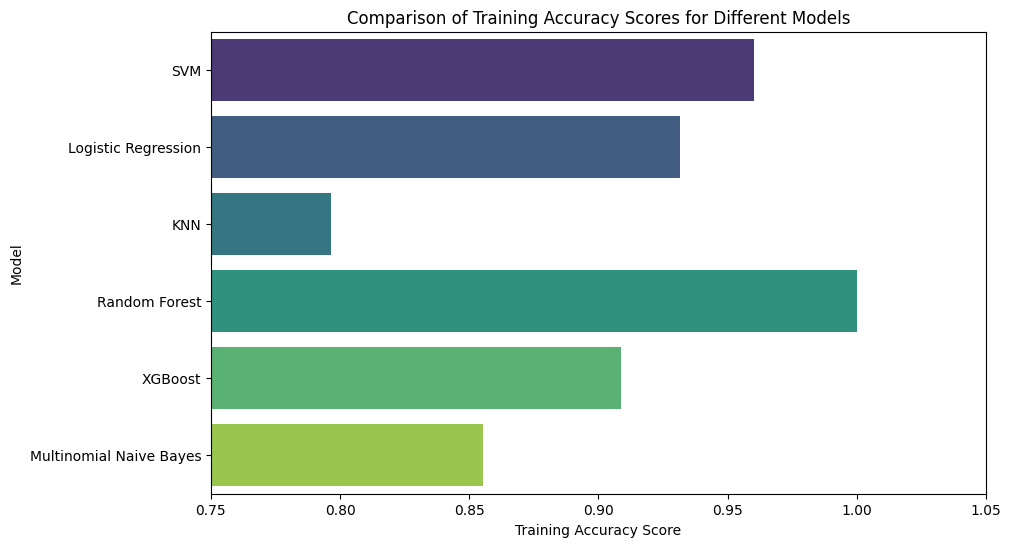

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for models and their training accuracy scores
models = ["SVM", "Logistic Regression", "KNN", "Random Forest", "XGBoost", "Multinomial Naive Bayes"]
train_scores = [0.9601, 0.9314, 0.7966, 1.0, 0.9086, 0.8552]

# Creating a DataFrame
df = pd.DataFrame({"Model": models, "Training Accuracy": train_scores})

# Plotting the training accuracy scores
plt.figure(figsize=(10, 6))
sns.barplot(x="Training Accuracy", y="Model", data=df, palette="viridis")
plt.xlabel("Training Accuracy Score")
plt.ylabel("Model")
plt.title("Comparison of Training Accuracy Scores for Different Models")
plt.xlim(0.75, 1.05)
plt.show()



# Binary Count Vectorizer (10,000 Features) 


In [21]:
v = CountVectorizer(binary=True, lowercase=False, stop_words=None, token_pattern=r"(?u)\b[a-zA-Z]+\b", max_features=10000)
x_train_cvb = v.fit_transform(x_train)
x_valid_cvb = v.transform(x_valid)
x_test_cvb = v.transform(x_test)


### Models (SVM, Logistic Regression, KNN, Random Forests, XGBoost, Multinomial Naive Bayes, XGBoost) ###
### Binary 10000 ###

In [22]:
# SVM
svcb = SVC(C=0.1)
svcb.fit(x_train_cvb, y_train)
svcb_perd = svcb.predict(x_test_cvb)
print("SVM - Classification Report:")
print(classification_report(y_test, svcb_perd))
print("SVM - Accuracy Score on Training Data:", svcb.score(x_train_cvb, y_train))

# Logistic Regression
lgb = LogisticRegression(max_iter=1000)
lgb.fit(x_train_cvb, y_train)
lgb_perd = lgb.predict(x_test_cvb)
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, lgb_perd))
print("Logistic Regression - Accuracy Score on Training Data:", lgb.score(x_train_cvb, y_train))

# KNN
knnb = KNeighborsClassifier(n_neighbors=3)
knnb.fit(x_train_cvb, y_train)
knnb_perd = knnb.predict(x_test_cvb)
print("KNN - Classification Report:")
print(classification_report(y_test, knnb_perd))
print("KNN - Accuracy Score on Training Data:", knnb.score(x_train_cvb, y_train))

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train_cvb, y_train)
rf_pred = rf.predict(x_test_cvb)
print("Random Forest - Classification Report:")
print(classification_report(y_test, rf_pred))
print("Random Forest - Accuracy Score on Training Data:", rf.score(x_train_cvb, y_train))

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train_cvb, y_train)
xgb_pred = xgb_model.predict(x_test_cvb)
print("XGBoost - Classification Report:")
print(classification_report(y_test, xgb_pred))
print("XGBoost - Accuracy Score on Training Data:", xgb_model.score(x_train_cvb, y_train))

# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(x_train_cvb, y_train)
nb_pred = nb.predict(x_test_cvb)
print("Multinomial Naive Bayes - Classification Report:")
print(classification_report(y_test, nb_pred))
print("Multinomial Naive Bayes - Accuracy Score on Training Data:", nb.score(x_train_cvb, y_train))


SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      2493
           1       0.79      0.90      0.84      2507

    accuracy                           0.83      5000
   macro avg       0.84      0.83      0.83      5000
weighted avg       0.84      0.83      0.83      5000

SVM - Accuracy Score on Training Data: 0.8552857142857143
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2493
           1       0.86      0.87      0.86      2507

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Logistic Regression - Accuracy Score on Training Data: 0.9667714285714286
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.59      0.61      2493
  

# Non-Binary Count Vectorizer (10,000 Features) 


In [23]:
v = CountVectorizer(binary=False, lowercase=False, stop_words='english', token_pattern=r"(?u)\b[a-zA-Z]+\b", max_features=10000)
x_train_cv = v.fit_transform(x_train)
x_valid_cv = v.transform(x_valid)
x_test_cv = v.transform(x_test)

### Models (SVM, Logistic Regression, KNN, Random Forests, XGBoost, Multinomial Naive Bayes, XGBoost)###
### Non-Binary 10000 ###

In [24]:
# SVM
svc = SVC()
svc.fit(x_train_cv, y_train)
svc_perd = svc.predict(x_test_cv)
print("SVM - Classification Report:")
print(classification_report(y_test, svc_perd))
print("SVM - Accuracy Score on Training Data:", svc.score(x_train_cv, y_train))

# Logistic Regression
lg = LogisticRegression(max_iter=1000, n_jobs=-1)
lg.fit(x_train_cv, y_train)
lg_perd = lg.predict(x_test_cv)
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, lg_perd))
print("Logistic Regression - Accuracy Score on Training Data:", lg.score(x_train_cv, y_train))

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_cv, y_train)
knn_perd = knn.predict(x_test_cv)
print("KNN - Classification Report:")
print(classification_report(y_test, knn_perd))
print("KNN - Accuracy Score on Training Data:", knn.score(x_train_cv, y_train))

# Random Forest
rfbig = RandomForestClassifier(n_estimators=50)
rfbig.fit(x_train_cv, y_train)
rfbig_pred = rfbig.predict(x_test_cv)
print("Random Forest - Classification Report:")
print(classification_report(y_test, rfbig_pred))
print("Random Forest - Accuracy Score on Training Data:", rfbig.score(x_train_cv, y_train))

# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train_cv, y_train)
xgb_pred = xgb_model.predict(x_test_cv)
print("XGBoost - Classification Report:")
print(classification_report(y_test, xgb_pred))
print("XGBoost - Accuracy Score on Training Data:", xgb_model.score(x_train_cv, y_train))

# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(x_train_cv, y_train)
nb_pred = nb.predict(x_test_cv)
print("Multinomial Naive Bayes - Classification Report:")
print(classification_report(y_test, nb_pred))
print("Multinomial Naive Bayes - Accuracy Score on Training Data:", nb.score(x_train_cv, y_train))


SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2493
           1       0.85      0.90      0.87      2507

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

SVM - Accuracy Score on Training Data: 0.9508571428571428
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2493
           1       0.86      0.87      0.86      2507

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Logistic Regression - Accuracy Score on Training Data: 0.9721142857142857
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      2493
  

# Non-Binary Count Vectorizer (5,000 Features) 


In [25]:
v = CountVectorizer(binary=False, lowercase=False, stop_words='english', max_features=5000)
x_train_5 = v.fit_transform(x_train)
x_valid_5 = v.transform(x_valid)
x_test_5 = v.transform(x_test)

### Models (SVM, Logistic Regression, KNN, Random Forests, XGBoost, Multinomial Naive Bayes, XGBoost)###
### Non-Binary 5000 ###

In [26]:
# SVM
svc5 = SVC()
svc5.fit(x_train_5, y_train)
svc5_perd = svc5.predict(x_test_5)
print("SVM - Classification Report:")
print(classification_report(y_test, svc5_perd))
print("SVM - Accuracy Score on Training Data:", svc5.score(x_train_5, y_train))

# Logistic Regression
lgb5 = LogisticRegression(max_iter=1000, n_jobs=-1)
lgb5.fit(x_train_5, y_train)
lgb5_perd = lgb5.predict(x_test_5)
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, lgb5_perd))
print("Logistic Regression - Accuracy Score on Training Data:", lgb5.score(x_train_5, y_train))

# KNN
knnb = KNeighborsClassifier(n_neighbors=3)
knnb.fit(x_train_5, y_train)
knnb_perd = knnb.predict(x_test_5)
print("KNN - Classification Report:")
print(classification_report(y_test, knnb_perd))
print("KNN - Accuracy Score on Training Data:", knnb.score(x_train_5, y_train))

# Random Forest
rfb = RandomForestClassifier(n_estimators=100)
rfb.fit(x_train_5, y_train)
rfb_pred = rfb.predict(x_test_5)
print("Random Forest - Classification Report:")
print(classification_report(y_test, rfb_pred))
print("Random Forest - Accuracy Score on Training Data:", rfb.score(x_train_5, y_train))

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train_5, y_train)
xgb_pred = xgb_model.predict(x_test_5)
print("XGBoost - Classification Report:")
print(classification_report(y_test, xgb_pred))
print("XGBoost - Accuracy Score on Training Data:", xgb_model.score(x_train_5, y_train))

# Multinomial Naive Bayes
nb5 = MultinomialNB()
nb5.fit(x_train_5, y_train)
nb5_pred = nb5.predict(x_test_5)
print("Multinomial Naive Bayes - Classification Report:")
print(classification_report(y_test, nb5_pred))
print("Multinomial Naive Bayes - Accuracy Score on Training Data:", nb5.score(x_train_5, y_train))


SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2493
           1       0.85      0.90      0.87      2507

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

SVM - Accuracy Score on Training Data: 0.9479428571428572
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2493
           1       0.86      0.87      0.87      2507

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Logistic Regression - Accuracy Score on Training Data: 0.9351428571428572
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.59      0.62      2493
  

# Bigram Vectorizer (2-gram model, 10,000 Features) 


In [27]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=10000)
x_train_big = bigram_vectorizer.fit_transform(x_train)
x_valid_big = bigram_vectorizer.transform(x_valid)
x_test_big = bigram_vectorizer.transform(x_test)

### Models (SVM, Logistic Regression, KNN, Random Forests, XGBoost, Multinomial Naive Bayes, XGBoost)###
### Bigram 10000 ###

In [28]:
# SVM
svcbig = SVC()
svcbig.fit(x_train_big, y_train)
svcbig_perd = svcbig.predict(x_test_big)
print("SVM - Classification Report:")
print(classification_report(y_test, svcbig_perd))
print("SVM - Accuracy Score on Training Data:", svcbig.score(x_train_big, y_train))

# Logistic Regression
lgbig = LogisticRegression(max_iter=1000, n_jobs=-1)
lgbig.fit(x_train_big, y_train)
lgbig_perd = lgbig.predict(x_test_big)
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, lgbig_perd))
print("Logistic Regression - Accuracy Score on Training Data:", lgbig.score(x_train_big, y_train))

# KNN
knnbig = KNeighborsClassifier(n_neighbors=3)
knnbig.fit(x_train_big, y_train)
knnbig_perd = knnbig.predict(x_test_big)
print("KNN - Classification Report:")
print(classification_report(y_test, knnbig_perd))
print("KNN - Accuracy Score on Training Data:", knnbig.score(x_train_big, y_train))

# Random Forest
rfbig = RandomForestClassifier(n_estimators=85)
rfbig.fit(x_train_big, y_train)
rfbig_pred = rfbig.predict(x_test_big)
print("Random Forest - Classification Report:")
print(classification_report(y_test, rfbig_pred))
print("Random Forest - Accuracy Score on Training Data:", rfbig.score(x_train_big, y_train))

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train_big, y_train)
xgb_pred = xgb_model.predict(x_test_big)
print("XGBoost - Classification Report:")
print(classification_report(y_test, xgb_pred))
print("XGBoost - Accuracy Score on Training Data:", xgb_model.score(x_train_big, y_train))

# Multinomial Naive Bayes
nbbig = MultinomialNB()
nbbig.fit(x_train_big, y_train)
nbbig_pred = nbbig.predict(x_test_big)
print("Multinomial Naive Bayes - Classification Report:")
print(classification_report(y_test, nbbig_pred))
print("Multinomial Naive Bayes - Accuracy Score on Training Data:", nbbig.score(x_train_big, y_train))


SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      2493
           1       0.78      0.84      0.81      2507

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000

SVM - Accuracy Score on Training Data: 0.9463428571428572
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2493
           1       0.78      0.81      0.79      2507

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000

Logistic Regression - Accuracy Score on Training Data: 0.9254
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.84      0.65      2493
           1  

# STEP 3: Using the TF-IDF Vectorizer

###  Binary Tfidf 5000 ###

In [29]:

tfidfb = TfidfVectorizer(binary=True, lowercase=False, stop_words=None, max_features=5000)
x_train_tfidfb = tfidfb.fit_transform(x_train)
x_valid_tfidfb = tfidfb.transform(x_valid)
x_test_tfidfb = tfidfb.transform(x_test)


### svm ###

In [30]:
svc_tfidfb = SVC()
svc_tfidfb.fit(x_train_tfidfb, y_train)


y_valid_pred = svc_tfidfb.predict(x_valid_tfidfb)
y_test_pred = svc_tfidfb.predict(x_test_tfidfb)


print("Validation Set - Classification Report:")
print(classification_report(y_valid, y_valid_pred))

print("Test Set - Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Training Set Accuracy:", svc_tfidfb.score(x_train_tfidfb, y_train))


Validation Set - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4971
           1       0.88      0.89      0.88      5029

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2493
           1       0.87      0.89      0.88      2507

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Training Set Accuracy: 0.9812


### Non-Binary Tfidf 5000 ###

In [31]:
tfidf = TfidfVectorizer(binary=False, lowercase=False, stop_words=None, max_features=5000)
x_train_tfidf = tfidf.fit_transform(x_train)
x_valid_tfidf = tfidf.transform(x_valid)
x_test_tfidf = tfidf.transform(x_test)


### SVM ###

In [32]:

svc_tfidf = SVC()
svc_tfidf.fit(x_train_tfidf, y_train)

y_valid_pred = svc_tfidf.predict(x_valid_tfidf)
y_test_pred = svc_tfidf.predict(x_test_tfidf)

print("Validation Set - Classification Report:")
print(classification_report(y_valid, y_valid_pred))

print("Test Set - Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Training Set Accuracy:", svc_tfidf.score(x_train_tfidf, y_train))


Validation Set - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4971
           1       0.88      0.90      0.89      5029

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2493
           1       0.87      0.89      0.88      2507

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Training Set Accuracy: 0.9803714285714286
